In [28]:
!pip install --upgrade --quiet phiflow==2.2
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

from phi.flow import *  # The Dash GUI is not supported on Google colab, ignore the warning
import pylab

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
DT = 1.5
NU = 0.01

INFLOW = CenteredGrid(Sphere(center=tensor([30,15], channel(vector='x,y')), radius=10), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100))) * 0.2

In [30]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled in staggered form at face centers 

Max. velocity and mean marker density: [0.1558497, 0.008125]


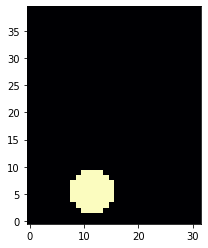

In [31]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity)
    return velocity, smoke, pressure

velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print("Max. velocity and mean marker density: " + format( [ math.max(velocity.values) , math.mean(smoke.values) ] ))

pylab.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma')

In [32]:
print(f"Smoke: {smoke.shape}")
print(f"Velocity: {velocity.shape}")
print(f"Inflow: {INFLOW.shape}, spatial only: {INFLOW.shape.spatial}")

Smoke: (xˢ=32, yˢ=40)
Velocity: (xˢ=32, yˢ=40, vectorᶜ=x,y)
Inflow: (xˢ=32, yˢ=40), spatial only: (xˢ=32, yˢ=40)


In [33]:
print(f"Shape content: {velocity.shape.sizes}")
print(f"Vector dimension: {velocity.shape.get_size('vector')}")

Shape content: (32, 40, 2)
Vector dimension: 2


In [34]:
print("Statistics of the different simulation grids:")
print(smoke.values)
print(velocity.values)

# in contrast to a simple tensor:
test_tensor = math.tensor(numpy.zeros([3, 5, 2]), spatial('x,y'), channel(vector="x,y"))
print("Reordered test tensor shape: " + format(test_tensor.numpy('vector,y,x').shape) ) # reorder to vector,y,x 
#print(test_tensor.values.numpy('y,x')) # error! tensors don't return their content via ".values"

Statistics of the different simulation grids:
(xˢ=32, yˢ=40) 0.008 ± 0.039 (0e+00...2e-01)
(xˢ=(x=31, y=32), yˢ=(x=40, y=39), vectorᶜ=x,y) -7.23e-09 ± 5.3e-03 (-1e-01...2e-01)
Reordered test tensor shape: (2, 5, 3)


In [35]:
for time_step in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    print('Computed frame {}, max velocity {}'.format(time_step , np.asarray(math.max(velocity.values)) ))

Computed frame 0, max velocity 0.463001
Computed frame 1, max velocity 0.896646
Computed frame 2, max velocity 1.4098884
Computed frame 3, max velocity 2.0411277
Computed frame 4, max velocity 2.927958
Computed frame 5, max velocity 3.8394766
Computed frame 6, max velocity 4.526946
Computed frame 7, max velocity 4.867982
Computed frame 8, max velocity 5.13108
Computed frame 9, max velocity 5.4838786


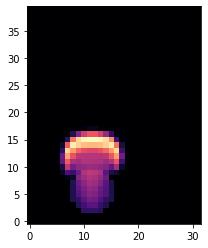

In [36]:
pylab.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma')

Computing time step 0
Computing time step 1
Computing time step 2
Computing time step 10


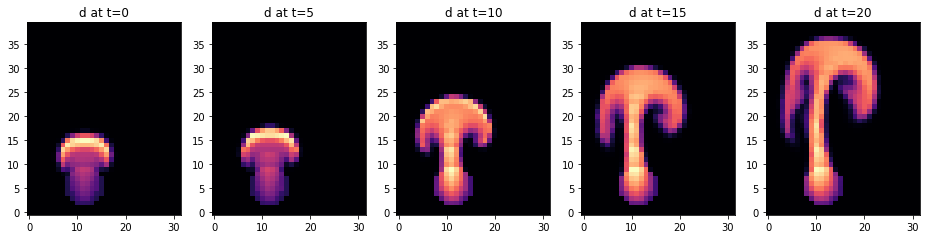

In [37]:
steps = [[ smoke.values, velocity.values.vector[0], velocity.values.vector[1] ]]
for time_step in range(20):
  if time_step<3 or time_step%10==0: 
    print('Computing time step %d' % time_step)
  velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
  if time_step%5==0:
    steps.append( [smoke.values, velocity.values.vector[0], velocity.values.vector[1]] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={i*5}")

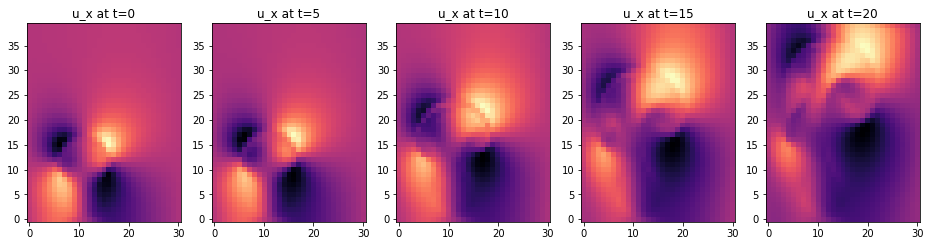

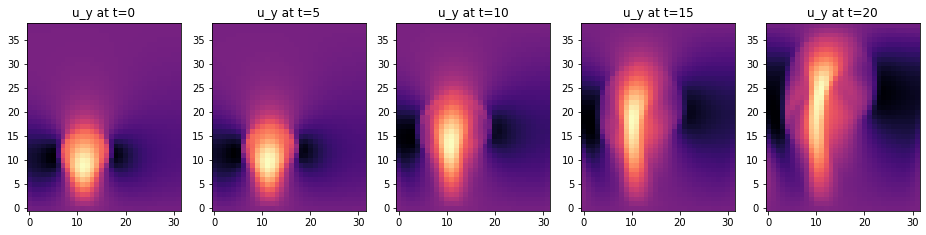

In [38]:
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][1].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_x at t={i*5}")
    
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][2].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_y at t={i*5}")
    